In [1]:
!pip install pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("RealTimeTask03") \
    .getOrCreate()


In [2]:
from google.colab import files
uploaded = files.upload()


Saving Online.csv to Online.csv


In [3]:
import pandas as pd
import os

# Load full dataset
df = pd.read_csv("Online.csv")

# Create folder for simulated streaming files
stream_path = "/content/stream_data"
os.makedirs(stream_path, exist_ok=True)

# Split into chunks of 100 rows
chunk_size = 100
for i in range(0, len(df), chunk_size):
    chunk = df.iloc[i:i+chunk_size]
    chunk.to_csv(f"{stream_path}/data_{i//chunk_size}.csv", index=False)


In [4]:
from pyspark.sql.types import *

schema = StructType([
    StructField("InvoiceNo", StringType(), True),
    StructField("StockCode", StringType(), True),
    StructField("Description", StringType(), True),
    StructField("Quantity", IntegerType(), True),
    StructField("InvoiceDate", StringType(), True),
    StructField("UnitPrice", DoubleType(), True),
    StructField("CustomerID", StringType(), True),
    StructField("Country", StringType(), True),
])


In [5]:
stream_df = spark.readStream \
    .schema(schema) \
    .option("maxFilesPerTrigger", 1) \
    .csv(stream_path)


In [6]:
from pyspark.sql.functions import col

stream_df = stream_df.withColumn("TotalValue", col("Quantity") * col("UnitPrice"))


In [7]:
agg_df = stream_df.groupBy("Country").sum("TotalValue")


In [8]:
query = agg_df.writeStream \
    .outputMode("complete") \
    .format("memory") \
    .queryName("sales_summary") \
    .start()


In [9]:
import time
time.sleep(10)  # Wait for a few files to be processed


In [10]:
spark.sql("SELECT * FROM sales_summary ORDER BY `sum(TotalValue)` DESC").show()


+--------------+------------------+
|       Country|   sum(TotalValue)|
+--------------+------------------+
|United Kingdom|2267.0699999999993|
|        France|            855.86|
|       Country|              NULL|
+--------------+------------------+



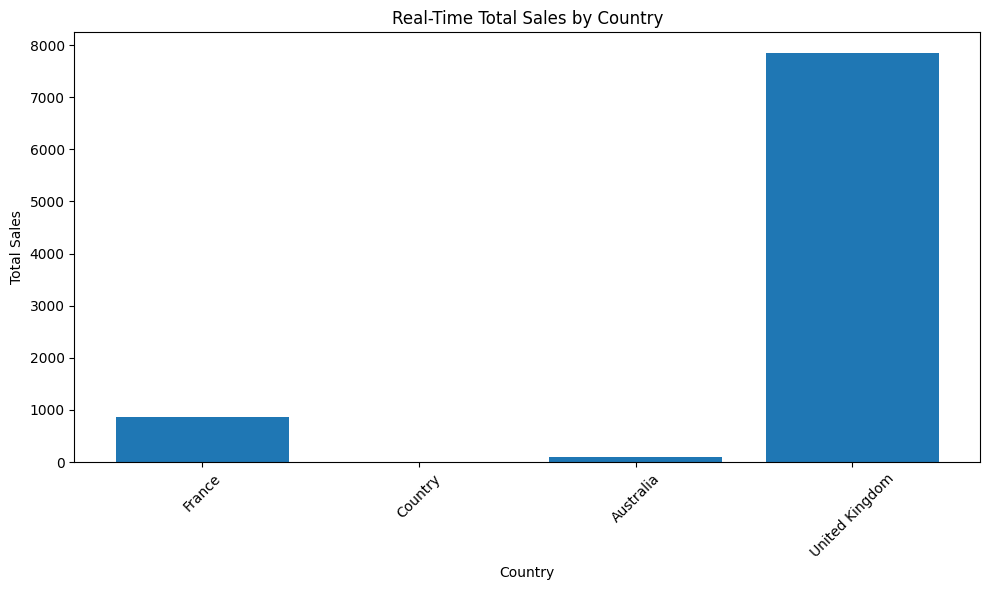

In [11]:
import matplotlib.pyplot as plt

# Convert to Pandas
pdf = spark.sql("SELECT * FROM sales_summary").toPandas()

# Bar chart
plt.figure(figsize=(10,6))
plt.bar(pdf['Country'], pdf['sum(TotalValue)'])
plt.title("Real-Time Total Sales by Country")
plt.xlabel("Country")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
